In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv('./Data/onet_tasks.csv')
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)

isco = []

for i in range(9):
    isco.append(pd.read_excel('./Data/Eurostat_employment_isco.xlsx', sheet_name=f'ISCO{i + 1}'))
    # We'll need a column that stores the occupation categories:
    isco[i]['ISCO'] = i + 1

# This gives us one large file with employment in all occupations.
all_data = pd.concat(isco, ignore_index=True)

# This will calculate worker totals in each of the chosen countries.
totals = all_data.groupby('TIME').sum().reset_index().drop(columns=['ISCO'])

countries = all_data.columns[~all_data.columns.isin(['TIME', 'ISCO', 'European Union - 28 countries (2013-2020)'])]

all_data_with_totals = pd.merge(all_data, totals, on='TIME', suffixes=('', '_total'))

In [3]:
# This will give us shares of each occupation among all workers in a period-country
for country in countries:
    all_data_with_totals[f'share_{country}'] = all_data_with_totals[country] / all_data_with_totals[f'{country}_total']

In [4]:
# Now let's look at the task data. We want the first digit of the ISCO variable only

task_data['isco08_1dig'] = task_data['isco08'].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(['isco08_1dig']).mean()
aggdata = aggdata.drop(columns=['isco08'])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

# Let's combine the data.
combined = pd.merge(all_data_with_totals, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')


In [5]:
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:

# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

task_items = ['t_4A2a4', 't_4A2b2', 't_4A4a1']

for country in countries:
    for task_item in task_items:
        temp_mean = np.average(combined[task_item], weights=combined[f'share_{country}'])
        temp_sd = np.sqrt(np.average((combined[task_item] - temp_mean) ** 2, weights=combined[f'share_{country}']))
        combined[f'std_{country}_{task_item}'] = (combined[task_item] - temp_mean) / temp_sd

In [6]:
# The next step is to calculate the `classic` task content intensity, i.e.
# how important is a particular general task content category in the workforce
# Here, we're looking at non-routine cognitive analytical tasks, as defined
# by David Autor and Darron Acemoglu:

aggregates = {}

for country in countries:
    combined[f'{country}_NRCA'] = combined[[f'std_{country}_{task_item}' for task_item in task_items]].sum(axis=1)
    # And we standardise NRCA in a similar way.
    temp_mean = np.average(combined[f'{country}_NRCA'], weights=combined[f'share_{country}'])
    temp_sd = np.sqrt(np.average((combined[f'{country}_NRCA'] - temp_mean) ** 2, weights=combined[f'share_{country}']))
    combined[f'std_{country}_NRCA'] = (combined[f'{country}_NRCA'] - temp_mean) / temp_sd
    # Finally, to track the changes over time, we have to calculate a country-level mean
    # Step 1: multiply the value by the share of such workers.
    combined[f'multip_{country}_NRCA'] = combined[f'std_{country}_NRCA'] * combined[f'share_{country}']
    # Step 2: sum it up (it basically becomes another weighted mean)
    aggregates[country] = combined.groupby(['TIME'])[f'multip_{country}_NRCA'].sum().reset_index()


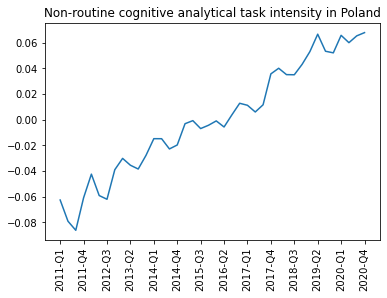

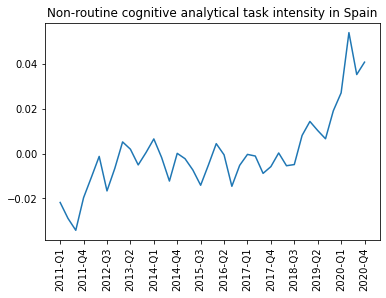

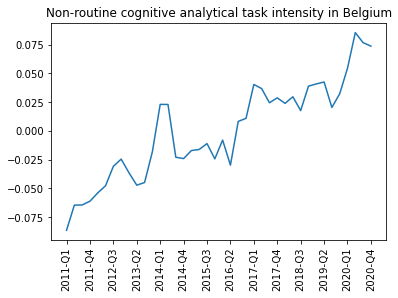

In [7]:
# We can plot it now!

for country in ['Poland', 'Spain', 'Belgium']:
    plt.plot(aggregates[country]['TIME'], aggregates[country][f'multip_{country}_NRCA'])
    plt.xticks(range(0, len(aggregates[country]), 3), aggregates[country]['TIME'][::3], rotation=90)
    plt.title(f'Non-routine cognitive analytical task intensity in {country}')
    plt.show()